### Introdução

Os codificadores automáticos variacionais (VAEs) podem ser considerados como o que todas as camadas de uma rede neural, exceto a última, estão fazendo, ou seja, extração de recursos ou separação dos dados. Assim, dados alguns dados, podemos pensar em usar uma rede neural para geração de representação.

Lembre-se de que o objetivo de um modelo generativo é estimar a distribuição de probabilidade de dados de alta dimensão, como imagens, vídeos, áudio ou mesmo texto, aprendendo a estrutura subjacente nos dados, bem como as dependências entre os diferentes elementos dos dados. Isto é muito útil porque podemos usar esta representação para gerar novos dados com propriedades semelhantes. Dessa forma, também podemos aprender recursos úteis dos dados de forma não supervisionada.

O VQ-VAE usa uma representação latente discreta principalmente porque muitos objetos importantes do mundo real são discretos. Por exemplo, em imagens podemos ter categorias como "Gato", "Carro", etc. e pode não fazer sentido interpolar entre estas categorias. Representações discretas também são mais fáceis de modelar, pois cada categoria tem um único valor, ao passo que, se tivéssemos um espaço latente contínuo, precisaríamos normalizar esta função de densidade e aprender as dependências entre as diferentes variáveis, que podem ser muito complexas.

### Arquitetura

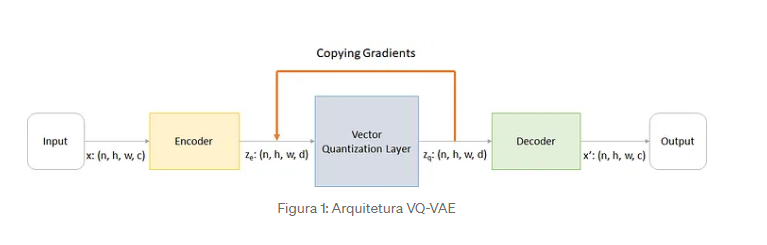

A Figura 1 mostra vários componentes de nível superior na arquitetura, juntamente com as dimensões de cada etapa. Supondo que executemos nosso modelo sobre dados de imagem, aqui estão algumas nomenclaturas que usaremos daqui para frente:

n: tamanho do lote

h: altura da imagem

w: largura da imagem

c: número de canais na imagem de entrada

d: número de canais no estado oculto

Agora o funcionamento pode ser explicado nas seguintes etapas:

- > O codificador recebe imagens x: (n, h, w, c) e fornece saídas z_e: (n, h, w, d)
- > A camada de quantização vetorial pega z_e e seleciona embeddings de um dicionário com base na distância e gera z_q 
- > O decodificador consome z_q e gera x' tentando recriar a entrada x


### Camada de Quantização Vetorial

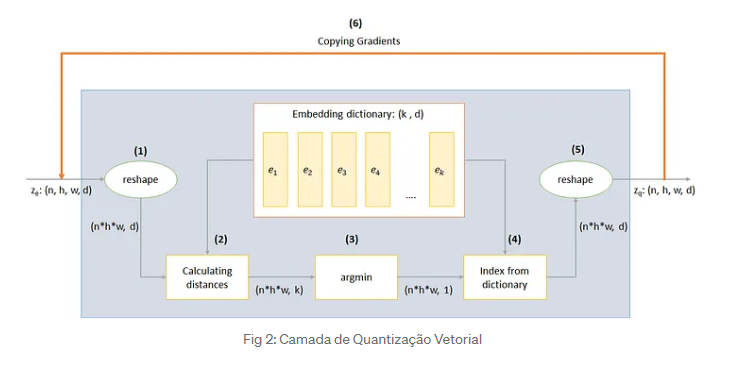

O funcionamento da camada VQ pode ser explicado em seis etapas numeradas na Figura 2:

- > Remodelar: todas as dimensões, exceto a última, são combinadas em uma, de modo que temos vetores n*h*w, cada um com dimensionalidade d
- >Calculando distâncias: para cada um dos vetores n*h*w calculamos a distância de cada um dos k vetores do dicionário de incorporação para obter uma matriz de forma (n*h*w, k)
- >Argmin: para cada um dos vetores n*h*w encontramos o índice do mais próximo dos k vetores do dicionário
- >Índice do dicionário: indexa o vetor mais próximo do dicionário para cada um dos vetores n*h*w
- >Remodelar: converter de volta para a forma (n, h, w, d)
- > É possível perceber que não é possível treinar essa arquitetura por meio de retropropagação, pois o gradiente não fluirá pelo argmin. Portanto, tentamos aproximar copiando os gradientes de z_q de volta para z_e. Dessa forma, não estamos realmente minimizando a função de perda, mas ainda somos capazes de repassar algumas informações para treinamento.

### Código

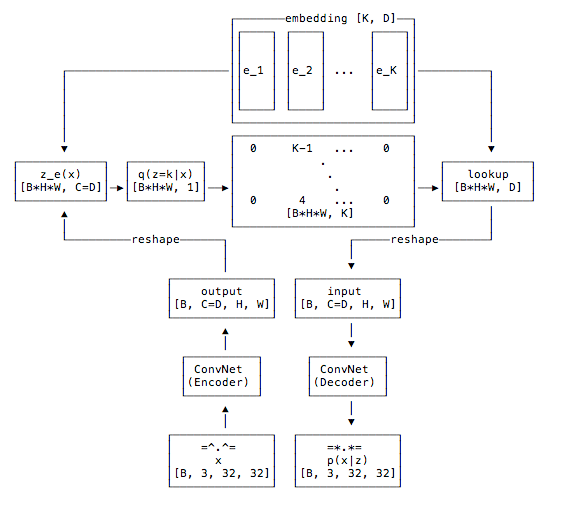

Começamos por definir um espaço de dimensão de embedding latente [K, D] onde K é o número de embaddings e D é a dimensionalidade de cada vetor de embedding latente, ou seja . O modelo é composto por um codificador e um decodificador.  O codificador mapeará a entrada para uma sequência de variáveis ​​latentes discretas, enquanto o decodificador tentará reconstruir a entrada a partir dessas sequências latentes.

Mais precisamente, o modelo irá capturar lotes de imagens RGB, digamos x
, cada um de tamanho 32x32 para nosso exemplo, e passá-lo por um codificador ConvNet produzindo alguma saídaE( x )
, onde garantimos que os canais sejam iguais à dimensionalidade dos vetores de embeddings latentes. Para calcular a variável latente discreta, encontramos o vetor de embedding mais próximo e produzimos seu índice.

A entrada para o decodificador é o vetor de embedding correspondente ao índice que é passado através do decodificador para produzir a imagem reconstruída.

Como a pesquisa do vizinho mais próximo não tem gradiente real na passagem para trás, simplesmente passamos os gradientes do decodificador para o codificador inalterados. A intuição é que, como a representação de saída do codificador e a entrada do decodificador compartilham o mesmo Despaço dimensional do canal, os gradientes contêm informações úteis sobre como o codificador deve alterar sua saída para diminuir a perda de reconstrução.

### Loss

A perda total é na verdade composta por três componentes


- > reconstruction loss: que otimiza o decodificador e o codificador
- > codebook loss: devido ao fato de que os gradientes ignoram a incorporação, usamos um algoritmo de aprendizado de dicionário que usa  erro ao mover os vetores de embeddings em direção à saída do codificador
- > commitment loss: como o volume do espaço de incorporação é adimensional, ele pode crescer arbitrariamente se os embeddings não treinamos tão rápido quanto os parâmetros do codificador e, portanto, adicionamos uma perda de compromisso para garantir que o codificador se comprometa com uma incorporação

In [126]:
#!pip3 install -U -r requirements.txt


In [127]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

#import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [128]:
# verifica se o PyTorch detecta uma GPU disponível no sistema. 
# Se uma GPU estiver disponível, ele usa "cuda" (que é o nome associado às GPUs NVIDIA no PyTorch); 
#caso contrário, ele usa "cpu" para indicar que as operações serão executadas na CPU.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Load data

In [129]:
# Carregue o conjunto de dados CIFAR-10 para treinamento
training_data = datasets.CIFAR10(
    root="data",         # Diretório onde os dados serão armazenados após o download
    train=True,          # Indica que estamos carregando o conjunto de treinamento
    download=True,       # Baixa o conjunto de dados se ainda não estiver disponível
    transform=transforms.Compose([  # Aplica transformações aos dados
        transforms.ToTensor(),      # Converte as imagens em tensores do PyTorch
        transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))  # Normaliza os valores dos tensores
    ])
)

# Carregue o conjunto de dados CIFAR-10 para validação (conjunto de teste)
validation_data = datasets.CIFAR10(
    root="data",         # Mesmo diretório de armazenamento dos dados
    train=False,         # Indica que estamos carregando o conjunto de teste
    download=True,       # Baixa o conjunto de dados de teste se ainda não estiver disponível
    transform=transforms.Compose([  # Aplica as mesmas transformações aos dados de teste
        transforms.ToTensor(),      # Converte as imagens em tensores do PyTorch
        transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))  # Normaliza os valores dos tensores
    ])
)

Files already downloaded and verified
Files already downloaded and verified


In [130]:
data_variance = np.var(training_data.data / 255.0)


### visualizando imagens

Files already downloaded and verified


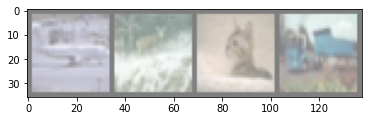

plane deer  cat   truck


In [131]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

# Conjunto de dados CIFAR-10
transform = transforms.Compose([transforms.ToTensor()])
cifar_10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(cifar_10, batch_size=4, shuffle=True)

# Classes do CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Função para mostrar imagens
def imshow(img):
    img = img / 2 + 0.5  # Desfaz a normalização
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#lote de dados
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Imagens e rótulos
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


### Visualizando dimensões das imagens originais e das imagens normalizadas

In [132]:
#Conjunto de dados CIFAR-10 original
original_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

# Obtenha um lote de imagens normalizadas
normalized_images, _ = next(iter(training_data))
# Obtenha um lote de imagens originais
original_images, _ = next(iter(original_data))

# Imprima as dimensões das imagens
print("Dimensões das imagens normalizadas:", normalized_images.size())
print("Dimensões das imagens originais:", original_images.size())


Files already downloaded and verified
Dimensões das imagens normalizadas: torch.Size([3, 32, 32])
Dimensões das imagens originais: torch.Size([3, 32, 32])


### Camada de quantizador vetorial

A camada de quantização vetorial é uma técnica que ajuda a moldar e melhorar o espaço latente, tornando-o discreto e com uma estrutura definida. No entanto, o espaço latente pode existir sem a camada de quantização vetorial, mas com ela, pode se tornar mais apropriado para certas tarefas e aplicações. A decisão de usar uma camada VQ depende do objetivo do modelo e das necessidades da tarefa.

Uma camada de quantização (VQ Layer) serve para discretizar um espaço contínuo de características em um espaço discreto, criando um conjunto finito de códigos ou índices que representam as características. Ela é comumente usada em modelos de geração e representação de dados, como os modelos generativos adversariais discretos (DAGANs) e redes neurais autoencoder variacionais discretos (Discrete-VAEs). A camada VQ desempenha um papel importante em tarefas como compressão de dados, geração de imagens e representação de alta dimensão.

Aqui está um exemplo de como uma camada de quantização pode ser usada em um DAGAN para geração de imagens:

1. **Codificação (Encoder)**: Um modelo, como uma rede neural, codifica uma imagem em um espaço latente contínuo. O espaço latente contínuo contém informações sobre a imagem, mas é difícil de representar de forma compacta.

2. **Camada de Quantização (VQ Layer)**: A camada de quantização mapeia o espaço latente contínuo em um espaço latente discreto, onde os valores são índices que apontam para vetores de código em um dicionário finito. Isso cria uma representação discreta e compacta das características da imagem.

3. **Decodificação (Decoder)**: O modelo, em seguida, decodifica os códigos de volta para o espaço latente contínuo e, finalmente, gera uma imagem reconstruída com base nessa representação discreta. A rede decodificadora é treinada para produzir imagens de alta qualidade a partir dos códigos discretos.

Exemplo:
Imagine um DAGAN que gera imagens de rostos. A camada de quantização pode ser usada para discretizar as características dos rostos, como a forma dos olhos, nariz, boca etc. Os códigos discretos representariam diferentes arranjos dessas características. Portanto, a camada de quantização cria um espaço latente discreto que representa eficazmente os arranjos de características que podem ser usados para gerar imagens de rostos realistas.

A camada de quantização é útil porque torna o espaço latente mais compacto, interpretação e eficiente, o que pode ser benéfico para a geração de dados e outras tarefas. Ela permite que um modelo capture as principais características de dados complexos com uma quantidade relativamente pequena de informações discretas.

No caso desse trabalho, a camada leva um tensor para ser quantizado. A dimensão do canal será usada como o espaço no qual quantizar. Todas as outras dimensões serão achatadas e serão vistas como exemplos diferentes para quantizar.

O tensor de saída terá o mesmo formato da entrada.

Como exemplo de um BCHWtensor de forma [16, 64, 32, 32], primeiro o converteremos em um BHWCtensor de forma [16, 32, 32, 64]e depois o remodelaremos [16384, 64]e todos os 16384vetores de tamanho 64 serão quantizados independentemente. Em outras palavras, os canais são usados ​​como espaço para quantização. Todas as outras dimensões serão achatadas e vistas como diferentes exemplos de quantização, 16384neste caso.

In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        # Cria uma camada de embedding com num_embeddings vetores de dimensão embedding_dim
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        
        # Inicializa os vetores de embedding com valores uniformes no intervalo [-1/num_embeddings, 1/num_embeddings]
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # Converte as entradas de formato BCHW para BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Achatamento da entrada
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calcula as distâncias entre os vetores de entrada e os vetores de embedding
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Codificação
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantização e reconstrução da entrada original
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Cálculo da perda
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        # Atualiza a representação quantizada
        quantized = inputs + (quantized - inputs).detach()
        
        # Cálculo da perplexidade (uma medida de quão bem as probabilidades de codificação se espalham)
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # Converte quantized de BHWC para BCHW antes de retornar
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings


Também implementaremos uma versão ligeiramente modificada que usará médias móveis exponenciais para atualizar os vetores de incorporação em vez de uma perda auxiliar. Isto tem a vantagem de que as atualizações de incorporação são independentes da escolha do otimizador para o codificador, decodificador e outras partes da arquitetura. Para a maioria dos experimentos, a versão EMA treina mais rápido que a versão não EMA.

In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        # Cria uma camada de embedding com num_embeddings vetores de dimensão embedding_dim
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        # Registra um buffer (tensor não treinável) para armazenar o tamanho do cluster EMA
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        
        # Inicializa os vetores EMA
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # Converte as entradas de formato BCHW para BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Achatamento da entrada
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calcula as distâncias entre os vetores de entrada e os vetores de embedding
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Codificação
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantização e reconstrução da entrada original
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA para atualizar os vetores de embedding
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Suavização de Laplace do tamanho do cluster
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            # Atualiza os vetores de embedding com base nos vetores EMA
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Cálculo da perda
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Estimador "Straight Through"
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # Converte quantized de BHWC para BCHW antes de retornar
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings


BHWC e BCHW são representações de formato de tensores usadas em deep learning, especialmente ao lidar com imagens e dados de imagens. Cada letra nessa notação representa uma dimensão específica do tensor.

- **BHWC**:
  - **B**: Batch (lote) - Esta dimensão refere-se ao número de exemplos ou amostras em um lote. Lotes são frequentemente usados no treinamento de modelos de aprendizado profundo para processar várias amostras ao mesmo tempo, melhorando a eficiência do treinamento.
  - **H**: Height (altura) - Essa dimensão representa a altura da imagem ou dos dados. Em uma imagem, essa dimensão é vertical, indicando o número de pixels na vertical.
  - **W**: Width (largura) - Essa dimensão representa a largura da imagem ou dos dados. Em uma imagem, essa dimensão é horizontal, indicando o número de pixels na horizontal.
  - **C**: Channel (canal) - Essa dimensão refere-se ao número de canais ou mapas de características em um tensor. Em imagens coloridas, geralmente temos três canais correspondentes às cores vermelha, verde e azul (RGB). Em imagens em escala de cinza, temos apenas um canal.

- **BCHW**:
  - **B**: Batch (lote) - Igual ao BHWC, refere-se ao número de exemplos ou amostras em um lote.
  - **C**: Channel (canal) - Também igual ao BHWC, refere-se ao número de canais ou mapas de características.
  - **H**: Height (altura) - Essa dimensão representa a altura da imagem ou dos dados.
  - **W**: Width (largura) - Essa dimensão representa a largura da imagem ou dos dados.

A escolha entre BHWC e BCHW depende da biblioteca e da arquitetura da rede neural que está sendo usada. Alguns frameworks, como PyTorch, preferem a notação BCHW, enquanto outros, como TensorFlow, usam a notação BHWC. A notação é importante porque afeta a forma como as operações de convolução e outras operações de processamento de imagem são aplicadas. Portanto, ao lidar com tensores em deep learning, é essencial estar ciente do formato das dimensões e como ele afeta as operações em sua rede.

### Encoder / Decoder Architecture

A arquitetura do codificador e decodificador é baseada em um ResNet e é implementada abaixo:



In [135]:
import torch.nn as nn
import torch.nn.functional as F

# Definindo um bloco residual
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        
        # Definindo um bloco sequencial com duas camadas convolucionais seguidas de funções de ativação ReLU
        self._block = nn.Sequential(
            nn.ReLU(True),  # Função de ativação ReLU
            nn.Conv2d(in_channels=in_channels, out_channels=num_residual_hiddens, kernel_size=3, stride=1, padding=1, bias=False),  # Primeira camada convolucional
            nn.ReLU(True),  # Função de ativação ReLU
            nn.Conv2d(in_channels=num_residual_hiddens, out_channels=num_hiddens, kernel_size=1, stride=1, bias=False)  # Segunda camada convolucional
        )
    
    def forward(self, x):
        # A saída é a entrada mais o resultado do bloco residual
        return x + self._block(x)

# Definindo uma pilha de blocos residuais
class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        
        self._num_residual_layers = num_residual_layers
        # Cria uma lista de módulos Residual para formar a pilha
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        # Passa a entrada por cada bloco residual na pilha
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        # Aplica uma função de ativação ReLU à saída final
        return F.relu(x)


In [136]:
# Importações necessárias do PyTorch
import torch.nn as nn
import torch.nn.functional as F

# Definindo a classe do codificador (Encoder)
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        # Definindo a primeira camada convolucional (conv_1)
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        # Definindo a segunda camada convolucional (conv_2)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        # Definindo a terceira camada convolucional (conv_3)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        
        # Criando um stack residual usando a classe ResidualStack
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    # Implementando a passagem para a frente (forward pass) do codificador
    def forward(self, inputs):
        # Passando a entrada através da primeira camada convolucional (conv_1)
        x = self._conv_1(inputs)
        x = F.relu(x)  # Aplicando uma função de ativação ReLU à saída
        
        # Passando a saída da primeira camada pela segunda camada convolucional (conv_2)
        x = self._conv_2(x)
        x = F.relu(x)  # Aplicando ReLU novamente
        
        # Passando a saída da segunda camada pela terceira camada convolucional (conv_3)
        x = self._conv_3(x)
        
        # Passando a saída pela pilha residual definida anteriormente
        return self._residual_stack(x)


#### Explicações extras

Em uma camada convolucional (convolução), várias operações matemáticas são realizadas para processar dados, geralmente em formato de tensores, comumente usados em tarefas de processamento de imagens. As camadas convolucionais são uma parte fundamental em arquiteturas de redes neurais convolucionais (ConvNets) e são projetadas para extrair recursos e informações relevantes dos dados de entrada. Aqui estão os principais componentes e operações em uma camada convolucional:

1. **Convolução**:
   - A operação de convolução envolve a aplicação de filtros (também chamados de kernels) aos dados de entrada. Cada filtro é uma matriz de pesos que desliza ou convoluciona sobre os dados de entrada.
   - A convolução calcula o produto escalar entre o filtro e uma região local dos dados de entrada e gera uma ativação (valor) em uma matriz de saída, chamada de mapa de características.
   - Essa operação é usada para detectar padrões, bordas e características relevantes nos dados de entrada.

2. **Padding**:
   - O padding (preenchimento) é uma técnica que adiciona zeros ou valores apropriados ao redor dos dados de entrada antes da convolução. Isso é feito para controlar o tamanho da saída da convolução e garantir que não haja perda de informações nas bordas dos dados.

3. **Stride**:
   - O stride (passo) determina o deslocamento do filtro durante a convolução. Um stride maior resulta em uma saída menor, enquanto um stride menor produz uma saída maior em relação à entrada.

4. **Função de Ativação**:
   - Após a convolução, uma função de ativação, como ReLU (Rectified Linear Unit), é aplicada para introduzir não linearidade na camada. Isso ajuda a aprender relações não lineares nos dados.

5. **Pooling (Agrupamento)**:
   - Camadas de pooling (também chamadas de camadas de subsamostragem) reduzem as dimensões da saída da camada convolucional, diminuindo a resolução espacial dos mapas de características.
   - O pooling é feito tomando o máximo valor (max-pooling) ou a média dos valores em uma região local do mapa de características.

O objetivo principal de uma camada convolucional é aprender automaticamente os filtros ou características que são relevantes para a tarefa em questão. Esses filtros podem ser usados para detectar padrões específicos nos dados, como bordas, texturas ou características complexas em imagens. Conforme a informação é passada pelas camadas convolucionais em uma ConvNet, representações cada vez mais abstratas e de alto nível são aprendidas, tornando-as ideais para tarefas de classificação, detecção de objetos, segmentação de imagens e muito mais.

In [137]:
# Importações necessárias do PyTorch
import torch.nn as nn
import torch.nn.functional as F

# Definindo a classe do decodificador (Decoder)
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        # Definindo a primeira camada convolucional (conv_1)
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        # Criando um stack residual usando a classe ResidualStack
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        # Definindo a primeira camada de convolução transposta (conv_trans_1)
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        # Definindo a segunda camada de convolução transposta (conv_trans_2)
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=3,
                                                kernel_size=4, 
                                                stride=2, padding=1)

    # Implementando a passagem para a frente (forward pass) do decodificador
    def forward(self, inputs):
        # Passando a entrada através da primeira camada convolucional (conv_1)
        x = self._conv_1(inputs)
        
        # Passando a saída da primeira camada pelo stack residual definido anteriormente
        x = self._residual_stack(x)
        
        # Passando a saída do stack residual pela primeira camada de convolução transposta (conv_trans_1)
        x = self._conv_trans_1(x)
        x = F.relu(x)  # Aplicando uma função de ativação ReLU à saída
        
        # Passando a saída da primeira camada de convolução transposta pela segunda camada de convolução transposta (conv_trans_2)
        return self._conv_trans_2(x)


### Train

Usamos os hiperparâmetros do código do autor:


In [145]:
# Tamanho do lote (batch size) utilizado nos treinamentos
batch_size = 256

# Número de atualizações de treinamento (é uma quantidade arbitrária definida pelo usuário)
num_training_updates = 600

# Número de unidades (neurônios) nas camadas ocultas do modelo
num_hiddens = 128

# Número de unidades nas camadas residuais do modelo (usadas em blocos residuais)
num_residual_hiddens = 32

# Número de camadas residuais no modelo (usadas para adicionar profundidade)
num_residual_layers = 2

# Dimensão do espaço de incorporação (embedding) usado em algumas camadas do modelo
embedding_dim = 64

# Número de embeddings ou vetores de código (usados em camadas de quantização)
num_embeddings = 512

# Custo de comprometimento (commitment cost) usado em camadas de quantização
commitment_cost = 0.25

# Taxa de decaimento (decay) usada em camadas de quantização (geralmente entre 0.9 e 0.99)
decay = 0.99

# Taxa de aprendizado (learning rate) usada no treinamento do modelo
learning_rate = 1e-3

In [146]:
# Criação de um DataLoader para os dados de treinamento

# training_data é o conjunto de dados de treinamento que será carregado
training_loader = DataLoader(training_data, 

                             # Tamanho do lote (batch size) usado durante o treinamento
                             batch_size=batch_size, 

                             # Embaralhamento aleatório dos dados no DataLoader para aumentar a aleatoriedade
                             shuffle=True,

                             # Configuração para alocar tensores na memória da GPU (se disponível)
                             pin_memory=True)


In [147]:
# Criação de um DataLoader para os dados de validação

# validation_data é o conjunto de dados de validação que será carregado
validation_loader = DataLoader(validation_data,

                               # Tamanho do lote (batch size) usado durante a validação
                               batch_size=32,

                               # Embaralhamento aleatório dos dados no DataLoader para aumentar a aleatoriedade
                               shuffle=True,

                               # Configuração para alocar tensores na memória da GPU (se disponível)
                               pin_memory=True)


In [148]:
# Definição da classe do modelo
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()

        # Criação do codificador (Encoder)
        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        
        # Camada convolucional pré-quantização (usada antes da camada de quantização)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        
        # Verificação de se a camada de quantização usada é uma camada VectorQuantizerEMA ou VectorQuantizer
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        
        # Criação do decodificador (Decoder)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)

    # Implementação da passagem para a frente (forward pass) do modelo
    def forward(self, x):
        # Passa os dados de entrada pelo codificador
        z = self._encoder(x)
        
        # Passa a saída do codificador pela camada convolucional pré-quantização
        z = self._pre_vq_conv(z)
        
        # Realiza a quantização dos dados
        loss, quantized, perplexity, _ = self._vq_vae(z)
        
        # Passa os dados quantizados pelo decodificador
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity


In [149]:
# Criação de uma instância do modelo

# Criação do modelo usando a classe Model e fornecendo os hiperparâmetros necessários
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay)

# Movendo o modelo para um dispositivo (por exemplo, CPU ou GPU) especificado por 'device'
model = model.to(device)


In [150]:
# Criação de um otimizador Adam

# model.parameters() retorna uma lista de parâmetros do modelo que precisam ser otimizados
# lr=learning_rate define a taxa de aprendizado usada para ajustar os parâmetros
# amsgrad=False indica que o otimizador não utilizará a versão modificada do método AMSGrad
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)


In [151]:
from tqdm import tqdm

model.train()  # Define o modelo no modo de treinamento
train_res_recon_error = []  # Lista para armazenar os erros de reconstrução durante o treinamento
train_res_perplexity = []  # Lista para armazenar perplexidades durante o treinamento

# Loop de treinamento
for i in tqdm(range(num_training_updates)):
    (data, _) = next(iter(training_loader))  # Obtém um lote de dados de treinamento
    data = data.to(device)  # Move os dados para o dispositivo (CPU ou GPU)
    optimizer.zero_grad()  # Zera os gradientes acumulados

    vq_loss, data_recon, perplexity = model(data)  # Realiza a passagem para a frente e calcula a perda
    recon_error = F.mse_loss(data_recon, data) / data_variance  # Calcula o erro de reconstrução
    loss = recon_error + vq_loss  # Calcula a perda total
    loss.backward()  # Calcula os gradientes
    optimizer.step()  # Atualiza os pesos do modelo com base nos gradientes

    train_res_recon_error.append(recon_error.item())  # Armazena o erro de reconstrução atual na lista
    train_res_perplexity.append(perplexity.item())  # Armazena a perplexidade atual na lista

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))  # Imprime o número de iterações concluídas
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))  # Imprime a média dos últimos 100 erros de reconstrução
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))  # Imprime a média das últimas 100 perplexidades
        print()


 17%|█████████████▎                                                                  | 100/600 [05:42<29:58,  3.60s/it]

100 iterations
recon_error: 1.010
perplexity: 1.000



 33%|██████████████████████████▋                                                     | 200/600 [11:14<21:34,  3.24s/it]

200 iterations
recon_error: 0.985
perplexity: 1.000



 50%|████████████████████████████████████████                                        | 300/600 [16:38<16:09,  3.23s/it]

300 iterations
recon_error: 0.983
perplexity: 1.000



 67%|█████████████████████████████████████████████████████▎                          | 400/600 [22:06<10:59,  3.30s/it]

400 iterations
recon_error: 0.975
perplexity: 1.000



 83%|██████████████████████████████████████████████████████████████████▋             | 500/600 [27:33<05:25,  3.26s/it]

500 iterations
recon_error: 0.978
perplexity: 1.000



100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [33:00<00:00,  3.30s/it]

600 iterations
recon_error: 0.723
perplexity: 2.038



### Plot loss

In [152]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

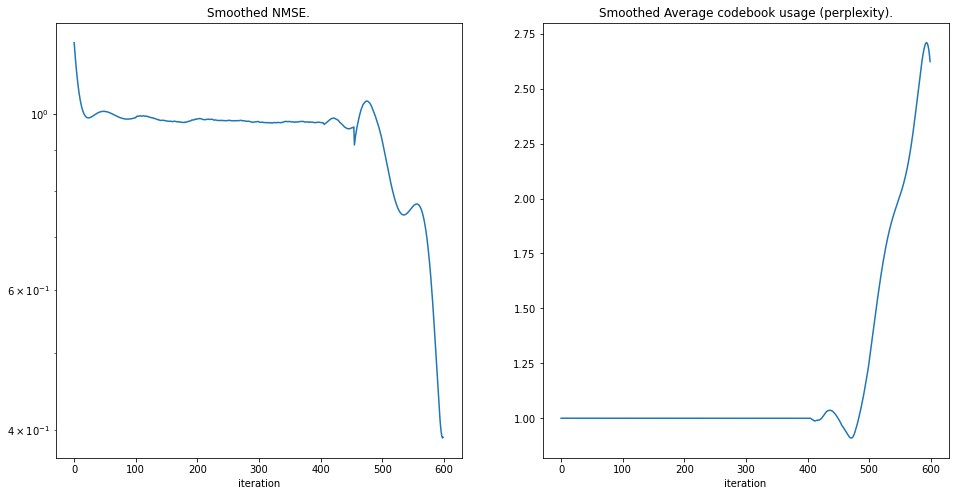

In [155]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

### View Reconstructions

In [156]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [157]:
(train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

In [158]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


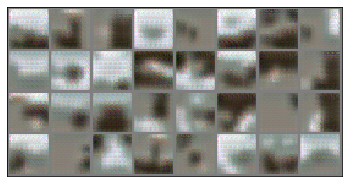

In [159]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )


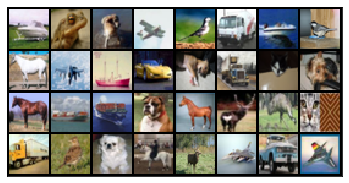

In [160]:
show(make_grid(valid_originals.cpu()+0.5))


### View Embedding

In [161]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

NameError: name 'umap' is not defined

In [162]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)


NameError: name 'proj' is not defined